# Toronto Pathways
In this notebook, I construct the input data to `urbanopt`. The input data is a geodataframe of pathways, which we define as individual & geolocated opportunities to add housing within a given area (more explanation is given below). 

## Definitions
**Pathways**
In this notebook, I stick to four "gentle density" pathways: 

1. `bment` - Building a basement suite in a single family home
2. `vsplit` - Splitting a single family home into multiple floors
3. `adu` - Building an accessory dwelling unit
4. `p2lo` - Building a low-rise on a parking lot

I've use the `urbanid` package to do some preliminary identification for each of these pathways, and I will load that data here.

**Opportunity**
I define opportunity as the number of *people* that can be added with a given pathway.

**Costs**
I define the following costs (note that I do not optimize over all of them at once
- `cost_emb` - The embodied carbon cost per m<sup>2</sup> of total floor area (i.e. including wall/stair footprints)
- `cost_bus` - The distance from the centroid of a given pathway to the nearest bus stop
- `cost_train` - As above, but for trains
- `cost_transit` - A hybrid score generated by combining the two above costs

## A note on pathways
To construct pathways for optimization we need our data in the form outlined in [pathways.py](../urbanity/pathways.py). Mainly, we need the following columns:
- `pid` the pathway id
- `label` A short, unique descriptor of the pathway type
- `start` the pathway start form (e.g. SFH)
- `end` the pathway ending form (e.g. ADU)
- `desc` a description of the pathway
- `opportunity` the housing opportunity provided by the pathway (i.e. the number of people that can be added through this pathway)
- `geometry` the geometry of the starting form in EPSG:4326
- `cost_x` any number of columns containing cost information for the multi-objective optimization

# Setup

In [1]:
import sys
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
working_dir = Path.cwd()
proj_crs = "EPSG:3347"

In [3]:
# Building data
bd = gpd.read_parquet(working_dir/"input_data"/f"{working_dir.stem}_buildings.parquet")
bd.sample(3)

,id,geometry,area,height,address_indices,address,volume,sfh_size,sfh,form,floors
4192,4204,"POLYGON ((-79.42136 43.64905, -79.42133 43.648...",63.744296,NaN,[],[],NaN,False,False,None,0
194984,195032,"POLYGON ((-79.33267 43.67016, -79.33267 43.670...",160.761820,5.980198,"[518992.0, 518996.0]","[1136 gerrard st e former toronto, 1138 gerrar...",961.387501,True,True,semi,2
158303,158347,"POLYGON ((-79.50465 43.67747, -79.50475 43.677...",105.788487,4.581531,[234237.0],[91 cynthia rd york],484.673239,True,True,single,2


In [4]:
# Plot (property) data
pl = gpd.read_parquet(working_dir/"input_data"/f"{working_dir.stem}_plots.parquet")
pl.sample(3)

,id,geometry,area,sfh,circle_rad_4,adu
366183,368103,"MULTIPOLYGON (((-79.45557 43.67208, -79.4556 4...",440.998441,False,True,False
262355,264208,"POLYGON ((-79.2866 43.76052, -79.28655 43.7605...",533.609365,True,True,True
127216,128912,"MULTIPOLYGON (((-79.52129 43.7467, -79.52123 4...",1139.877681,True,True,True


In [5]:
# Parking lot data
pr = gpd.read_parquet(working_dir/"input_data"/f"{working_dir.stem}_parking.parquet")
pr.sample(3)

,id,geometry,area,parking_160
4467,4467,"POLYGON ((-79.42539 43.72718, -79.42616 43.727...",1871.433086,True
8785,8785,"POLYGON ((-79.22916 43.72771, -79.22913 43.727...",1114.416260,False
7009,7009,"POLYGON ((-79.40273 43.65731, -79.4027 43.6572...",247.476213,True


# Opportunity
Per census data for the city of toronto census subdivision](https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/details/page.cfm?Lang=E&GENDERlist=1&STATISTIClist=1&HEADERlist=0&DGUIDlist=2021A00053520005&SearchText=toronto) Toronto has the following porportion of bedrooms per housing unit: 

- No beds: 0.025
- 1 beds: 0.285
- 2 beds: 0.288
- 3 beds: 0.231
- 4+ beds: 0.171

To get the opportunity for a given unit, we sort all possible units by area, assign the smallest 31% (2.5% + 28.5%) to 1 beds, the next largest 28% to 2 beds, and so on. Note the following: 

- No beds and 1 beds are the same. Census data counts number of bedrooms, so these no-bed units are assumed to still have *a bed*, just not in a separate room.
- We say anything in the top 17% have 4 bedrooms. *The consequences of this assumption is that it will be emissions intensive to convert very large houses.*

---

**footnotes**

<sup>1</sup>We don't *need* to assume this, but I want to take advantage of the fact that I know the sqm of every starting pathway.

In [6]:
OPPCONST = {
    "BED_BREAKPOINTS": [80, 105, 130],       #Breakpoints from 1 bedroom to 2 bedroom etc
    "BED_PERCENTILES": [0.31, 0.598, 0.829], #Quantiles separating e.g. 1 bd from 2 bds
    "PPB": 1.05,                             #People per bedroom
    "ADU_FLOOR_AREA": 48,                    #Area per floor in an ADU
    "ADU_N_FLOORS": 2,                       #Max floors in an ADU
    "LO_MIN_SIZE": 40,                       #The minimum possible size of a 1-bedroom unit in a lowrise
    "LO_N_FLOORS": 4                         #The number of floors in the default lowrise
}

## `bment`
Our data already has every single family home labelled thanks to `urbanid`. 

To recap the assumptions used to generate this data: 

>First, label everything that *could* be a SFH by size. I use a 6m x 9m bungalow as the smallest (taken from measurements in Toronto), and a 20m x 20m 3-story mansion as the largest (although things can probably get *way* bigger than this). Floor heights are assumed to be 2.75 m.<sup>1</sup>
>
>Then: 
>1. assign the `single` label to every building that meets the SFH sizes and has only one address associated with it
>2. assign `semi` label to every building that meets the SFH sizes and has *two* addresses associated with it.
>3. assign the `sfh` label to every building that is either `single` or `semi`
>
>---
><sup>1</sup> This is based on me measuring bungalows in my neighbourhood. The first floor is assumed to be 4.0m to account for the roof height.


In [7]:
def bment_opportunity(percentile, form):
    """Determine the number of people that can fit in a basement apt in a SFH."""
    
    max_beds = len(OPPCONST["BED_PERCENTILES"])+1
    for i, p in enumerate(OPPCONST["BED_PERCENTILES"]):
        if percentile < p:
            return (i+1) * OPPCONST["PPB"]

    
    return max_beds * OPPCONST["PPB"]

In [8]:
bment = bd[bd["sfh"]].copy()
geoms = bment["geometry"]

# Create new columns
bment["label"] = "bment"
bment["start"] = "sfh"
bment["end"] = "multiplex"
bment["desc"] = "Adding a basement unit to a single family home"

# Duplicate semi-detached rows and halve the areas of duplicated rows. 
is_semi = bment["form"] == "semi"
bment = pd.concat([bment, bment[is_semi].copy()])
bment["tmp_area"] = bment["area"]
bment.loc[bment["form"] == "semi", "tmp_area"] /= 2

# Calculate opportunity
bment["ptile"] = bment["tmp_area"].rank(pct=True)
bment["opportunity"] = bment.apply(lambda r: bment_opportunity(r.ptile, r.form), axis=1)

# Collapse the duplicated rows
bment = bment.drop(columns=["geometry", "tmp_area", "ptile"])
agg_funcs = {col: "first" for col in bment.columns}
agg_funcs.update({"opportunity": "sum"})

bment = bment.groupby(bment.index).agg(agg_funcs)
bment["geometry"] = geoms
bment = gpd.GeoDataFrame(bment, geometry="geometry")

### Exploring

Text(0.5, 0, 'bment Bedrooms')

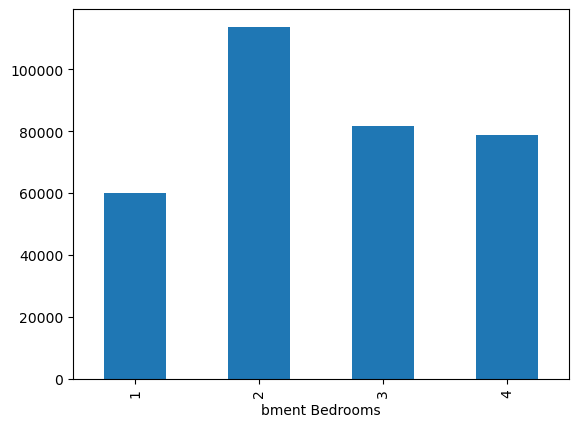

In [9]:
filtered = bment["opportunity"].astype(int)
filtered = filtered[filtered <= 4]
ax = filtered.value_counts().sort_index().plot(kind="bar")
ax.set_xlabel("bment Bedrooms")

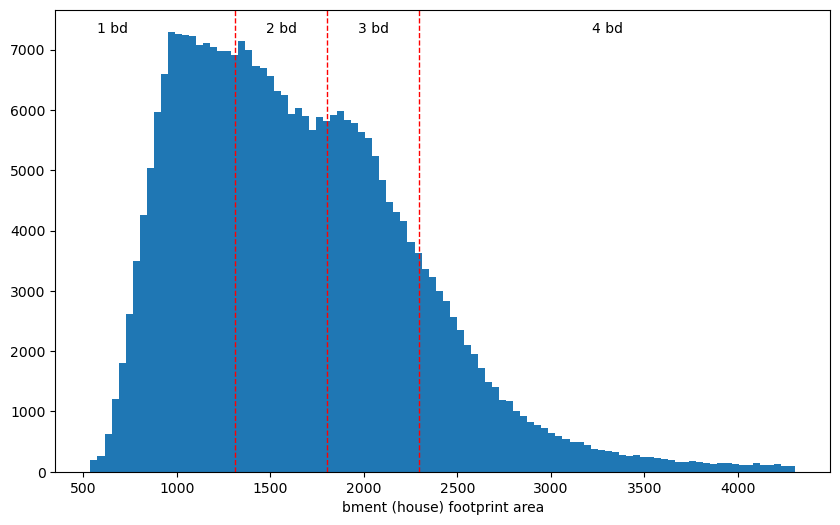

In [10]:
import matplotlib.pyplot as plt

# Filter for "single" form
filtered = bment[bment["form"] == "single"]

# Convert area to sqft
area_sqft = filtered["area"] * 10.7639

# Breakpoints in square meters and converted to sqft
breaks_sqft = [bment["area"].quantile(p)*10.7639 for p in OPPCONST["BED_PERCENTILES"]]
labels = ["1 bd", "2 bd", "3 bd", "4 bd"]

fig, ax = plt.subplots(figsize=(10, 6))  # wider plot
ax.hist(area_sqft, bins=100)
ax.set_xlabel("bment (house) footprint area")
ax.grid(False)

# Add vertical lines and labels
all_breaks = [0] + breaks_sqft + [area_sqft.max()]
for i in range(len(labels)):
    mid = (all_breaks[i] + all_breaks[i + 1]) / 2
    ax.text(mid, ax.get_ylim()[1] * 0.95, labels[i], ha="center", fontsize=10)
    if i < len(breaks_sqft):
        ax.axvline(breaks_sqft[i], color="red", linestyle="--", linewidth=1)


plt.show()


In [11]:
area_sqft.median()

1568.9196246992742

In [12]:
import lonboard
from lonboard import Map, ScatterplotLayer, PolygonLayer, viz
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.cmocean.sequential import Amp_18

from matplotlib import pyplot as plt

threshold = filtered["area"].quantile(0.99)
plot_df = filtered[filtered["area"] >= threshold]

def scaler(col):
    return (col - col.min()) / (col.max() - col.min())

building_colors = apply_continuous_cmap(
    values=scaler(plot_df["area"]),
    cmap=Amp_18
)

building_polys = PolygonLayer.from_geopandas(
    plot_df,
    get_fill_color=building_colors,
    extruded=True,
    get_elevation=plot_df["area"]/10
)

Map([building_polys], _height=800)

Map(custom_attribution='', layers=(PolygonLayer(extruded=True, get_elevation=arro3.core.ChunkedArray<Float32>
…

## `vsplit`
Our building data already has the estimated # of floors, which was calculated by assuming that the first floor takes up 4.0m<sup>1</sup>, and that every floor above that takes up 2.75m<sup>2</sup>.

---
<sup>1</sup> This is based on me measuring bungalows in my neighbourhood. The larger first floor accounts for the roofs.

<sup>2</sup> This is the standard floor size for residential buildings in Canada (9ft including structure).

In [13]:
def vsplit_opportunity(percentile, form, floors):
    """Determine the number of people that can fit in a basement apt in a SFH."""
    
    max_beds = len(OPPCONST["BED_PERCENTILES"])+1
    for i, p in enumerate(OPPCONST["BED_PERCENTILES"]):
        if percentile < p:
            return floors * (i+1) * OPPCONST["PPB"]

    
    return floors * max_beds * OPPCONST["PPB"]

In [14]:
vsplit = bd[bd["sfh"] & (bd["floors"] > 1)].copy()
geoms = vsplit["geometry"]

# Create new columns
vsplit["label"] = "vsplit"
vsplit["start"] = "sfh"
vsplit["end"] = "multiplex"
vsplit["desc"] = "Vertically splitting a multi-story SFH into new units"

# Duplicate semi-detached rows and halve the areas of duplicated rows. 
is_semi = vsplit["form"] == "semi"
vsplit = pd.concat([vsplit, vsplit[is_semi].copy()])
vsplit["tmp_area"] = vsplit["area"]
vsplit.loc[vsplit["form"] == "semi", "tmp_area"] /= 2

# Calculate opportunity
vsplit["ptile"] = vsplit["tmp_area"].rank(pct=True)
vsplit["opportunity"] = vsplit.apply(lambda r: vsplit_opportunity(r.ptile, r.form, r.floors), axis=1)

# Collapse the duplicated rows
vsplit = vsplit.drop(columns=["geometry", "tmp_area", "ptile"])
agg_funcs = {col: "first" for col in vsplit.columns}
agg_funcs.update({"opportunity": "sum"})

vsplit = vsplit.groupby(vsplit.index).agg(agg_funcs)
vsplit["geometry"] = geoms
vsplit = gpd.GeoDataFrame(vsplit, geometry="geometry")

## `adu`
The plot data already has plots labelled by whether or not they can fit a 6m circle, which used the following process:

1. Generate pseuplots around every building (voronoi diagram)
2. Subtract roads, greenspace, and parking lots
3. Calculate the maximum inscribed circle in the remaining plots
5. Flag any plots that contain a SFH and can fit a MIC with radius >= 4.25m (can fit a square between 6x6 and 8x8 meters)

Given this process, to calculate the opportunity we simply assume that every laneway house is 2-storeys, 7mx7m, for a total of 98m<sup>2</sup> of floor area per ADU. This conveniently puts us right in two-bedroom territory :).

In [15]:
def adu_opportunity(area):
    max_beds = len(OPPCONST["BED_BREAKPOINTS"])+1
    for i, b in enumerate(OPPCONST["BED_BREAKPOINTS"]):
        if area < b:
            return (i+1) * OPPCONST["PPB"]

    return max_beds * OPPCONST["PPB"]

In [16]:
# Filter correct subset
adu = pl[pl["circle_rad_4"] & pl["sfh"]].copy()

# Create pathways
adu["label"] = "adu"
adu["start"] = "backyard"
adu["end"] = "sfh"
adu["desc"] = "Adding an additional dwelling unit to on a single family home property"

adu["area"] = OPPCONST["ADU_FLOOR_AREA"]*OPPCONST["ADU_N_FLOORS"]

adu["opportunity"] = adu["area"].map(adu_opportunity)

In [17]:
print("Total Opportunity:", adu["opportunity"].sum())
adu.describe()

Total Opportunity: 569070.6000000002


,id,area,opportunity
count,270986.000000,270986.0,2.709860e+05
mean,215615.453296,96.0,2.100000e+00
std,119436.089482,0.0,1.066482e-11
min,5.000000,96.0,2.100000e+00
25%,116977.000000,96.0,2.100000e+00
50%,223945.500000,96.0,2.100000e+00
75%,318503.750000,96.0,2.100000e+00
max,411479.000000,96.0,2.100000e+00


## `p2lo`
Our parking lot data is pre-labelled with suitable parking lots by `urbanid`. As a reminder: 

>To identify suitable parking lots, we first download parking lots from OSM, and then flag those that:
> - Have areas above 160 sqm (this is enough for a two bedroom, per our standard breakpoints).
> - Have a minimum bounding rectangle with aspect ratio <= 4
> - Cover at least 80% of that bounding rectangle
>
>These last two conditions ensure we select roughly rectangular parking lots


For now I will assume that all suitable parking lots can fit a 4 storey building.<sup>1</sup>

In this case, we will assume units only occupy a single floor, and that all floors have the same footprint. I will fill the floors up with as many 80 sqm two bedrooms as possible, and then if the remaining area is btwn 40 and 80 sqm, I place a one bedroom.

I will use the previous number of `1.05` people per bedroom,

---

**footnotes**

<sup>1</sup>A low rise, which apparently is definitionally < 5 floors.

In [18]:
def p2lo_opportunity(area):
    n_beds = int(area / OPPCONST["BED_BREAKPOINTS"][0])
    
    if (area % n_beds) >= OPPCONST["LO_MIN_SIZE"]:
        n_beds += 1

    n_beds = n_beds * OPPCONST["LO_N_FLOORS"]
    
    return n_beds * OPPCONST["PPB"]

In [19]:
p2lo = pr[pr["parking_160"]].copy()

# Create pathways
p2lo["label"] = "p2lo"
p2lo["start"] = "parking"
p2lo["end"] = "lowrise"
p2lo["desc"] = "Converting a parking lot into a lowrise"

p2lo["opportunity"] = p2lo["area"].apply(p2lo_opportunity)

In [20]:
print("Total Opportunity:", p2lo["opportunity"].sum())
p2lo.describe()

Total Opportunity: 430512.6


,id,area,opportunity
count,4928.000000,4928.000000,4928.000000
mean,6720.060877,1700.774084,87.360511
std,3843.606738,3256.098808,171.317653
min,6.000000,160.083103,8.400000
25%,3376.750000,448.705732,21.000000
50%,6835.500000,795.927422,37.800000
75%,9971.500000,1645.670919,84.000000
max,13431.000000,86377.277552,4536.000000


# Costs

## cost_emb

### `bment`

The embodied carbon cost for each pathway of this type is determined using the following:

1. From [EEIO + Permitting Data](../data/toronto/eeio/EEIO_Toronto.ipynb), we see that adding a unit via renovation takes around 0.4% of the emissions of adding units via new housing.

2. We know from our [custom, bottom-up MFA data](https://pubmed.ncbi.nlm.nih.gov/35140241/) that new housing is 147 kg CO<sub>2</sub> / m<sup>2</sup> (+- 30)

3. We make the (admittedly rough) assumption that this means that renovations require $0.4*147=$ **60** kg CO<sub>2</sub> / m<sup>2</sup>

In [21]:
bment_ccsm = 0.4*147
bment["cost_emb"] = bment_ccsm*bment["area"]
bment["cost_emb"].describe()

count    338168.000000
mean       9343.398866
std        3491.511267
min        2941.227667
25%        6622.577499
50%        8897.661950
75%       11425.464887
max       23518.328659
Name: cost_emb, dtype: float64

### `vsplit`

This is the embodied carbon cost of this pathway, relative to that of a new single-family home. I determine this with the following methodology:

1. From [EEIO + Permitting Data](../data/toronto/eeio/EEIO_Toronto.ipynb), we see that adding a unit via renovation takes around 0.4% of the emissions of adding units via new housing.

2. We know from our [custom, bottom-up MFA data](https://pubmed.ncbi.nlm.nih.gov/35140241/) that new housing is 147 kg CO<sub>2</sub> / m<sup>2</sup> (+- 30)

3. We make the (admittedly rough) assumption that this means that renovations require $0.4*147=$ **60** kg CO<sub>2</sub> / m<sup>2</sup>

In [22]:
vsplit_ccsm = 0.4*147
vsplit["cost_emb"] = vsplit_ccsm * vsplit["area"] * vsplit["floors"]
vsplit["cost_emb"].describe()

count    315930.000000
mean      20089.884190
std        8487.417998
min        5900.828312
25%       13882.485562
50%       18787.184918
75%       24344.966001
max       93939.715875
Name: cost_emb, dtype: float64

### `adu`

This is the embodied carbon cost of ADU pathway, which we obtain from our [custom, bottom-up MFA data](https://pubmed.ncbi.nlm.nih.gov/35140241/) for housing in Toronto.

This data contains calculations of the embodied emissions from materials required for constructing a variety of homes. There are 38 examples of SFH in here, with an average GHG emissions of **147** kg CO<sub>2</sub> / m<sup>2</sup> (+- 30)

In [23]:
adu_ccsm = 147
adu["cost_emb"] = adu_ccsm * adu["area"] * OPPCONST["ADU_N_FLOORS"]
adu["cost_emb"].describe()

count    270986.0
mean      28224.0
std           0.0
min       28224.0
25%       28224.0
50%       28224.0
75%       28224.0
max       28224.0
Name: cost_emb, dtype: float64

### `p2lo`

This is the embodied carbon cost of building said 4-storey building, which we obtain from our [custom, bottom-up MFA data](https://pubmed.ncbi.nlm.nih.gov/35140241/) for housing in Toronto. This data contains calculations of the embodied emissions from materials required for constructing a variety of types of homes. There are 26 examples of low-rise construction in here.<sup>2</sup>

The average value for missing middle housing here is **196** kg CO<sub>2</sub> / m<sup>2</sup> (+- 69)



In [24]:
p2lo_ccsm = 196
p2lo["cost_emb"] = p2lo_ccsm * p2lo["area"] * OPPCONST["LO_N_FLOORS"]
p2lo["cost_emb"].describe()

count    4.928000e+03
mean     1.333407e+06
std      2.552781e+06
min      1.255052e+05
25%      3.517853e+05
50%      6.240071e+05
75%      1.290206e+06
max      6.771979e+07
Name: cost_emb, dtype: float64

## cost_transit

In order to determine `cost_transit` we first determine `cost_bus` and `cost_train`, which we define as the Euclidean distance from the centroid of a given pathway to its closest transit stop.

Transit stops are taken from GTFS data (in this case, StatsCan's [OpenTransitData](https://www150.statcan.gc.ca/n1/pub/23-26-0003/232600032025001-eng.htm) project). I've pre-filtered and joined the dataset to get only the important columns. The stops dataset has the following [route_types](https://gtfs.org/documentation/schedule/reference/#routestxt):
- `0` Tram/Streetcar
- `1` Subway
- `2` Rail (intercity or long distance)
- `3` Bus

We will group Streetcar (0) and Bus (3) types under `cost_bus`, and Subway (1) and Rail (2) under `cost_train`. This will allow us to weight them separately in the optimization problem, since some [literature](https://www.sciencedirect.com/science/article/pii/S2214140515006799) supports that people are more willing to walk to trains than they are to busses, etc.

---
Footnotes: 

~~The costs are simply the distance (in m) to a given transit stop, up to a maximum of 3000m. This is roughly when 50% of people would be unwilling to walk/bike to a transit stop, according to [Durand 2016](https://www.sciencedirect.com/science/article/pii/S2214140515006799). Having a max helps avoid situations where (e.g.) something is penalized heavily for being right next to a bus station but 20km from a train station (although I am not too sure how common such a situation would be)~~

Future direction:
- Incoporating some notion of how many transit stops are within distance X

In [25]:
MAX_DISTANCE = None
pathway_types = [bment, vsplit, adu, p2lo] # so we can loop through them

In [27]:
stops = gpd.read_parquet(working_dir/"input_data"/f"{working_dir.stem}_transit_stops.parquet")
stops.sample(3)

,agency,route_type,geometry
19654,york_region_transit,3.0,POINT (-79.46552 43.94621)
16067,york_region_transit,3.0,POINT (-79.4247 43.81648)
14069,durham_region_transit,3.0,POINT (-79.05009 43.8669)


In [28]:
# cost_bus
bus_stops = stops[stops["route_type"].isin([0, 3])].to_crs(proj_crs)

for pathways in pathway_types:
    pathways.reset_index()

    # join with stop data
    tmp = gpd.sjoin_nearest(
        pathways.to_crs(proj_crs),
        bus_stops,
        how="left",
        distance_col="cost_bus"
    )
    tmp = tmp.sort_values("index_right") #sorting by index_right for deterministic tie-break
    tmp = tmp[~tmp.index.duplicated(keep="first")]

    if MAX_DISTANCE:
        tmp["cost_bus"] = np.minimum(tmp["cost_bus"], MAX_DISTANCE)
    
    pathways["cost_bus"] = tmp["cost_bus"]

In [29]:
# cost_train
# train_stops = stops[stops["route_type"].isin([1, 2])].to_crs(proj_crs)
train_stops = stops[stops["route_type"].isin([1])].to_crs(proj_crs)

for pathways in pathway_types:
    pathways.reset_index()

    # join with stop data
    tmp = gpd.sjoin_nearest(
        pathways.to_crs(proj_crs),
        train_stops,
        how="left",
        distance_col="cost_train"
    )
    tmp = tmp.sort_values("index_right") #sorting by index_right for deterministic tie-break
    tmp = tmp[~tmp.index.duplicated(keep="first")]

    if MAX_DISTANCE:
        tmp["cost_train"] = np.minimum(tmp["cost_train"], MAX_DISTANCE)
    
    pathways["cost_train"] = tmp["cost_train"]

In [30]:
# cost_transit
for pathways in pathway_types: 
    pathways["cost_transit"] = pathways["cost_bus"] + 2*pathways["cost_train"]

In [31]:
# Unpacking
bment, vsplit, adu, p2lo = pathway_types

## cost_access
Similar to the cost_transit, this metric determines measures the accessibility of a given pathway.

This is determined using the [Spatial Accessibility Measures](https://www150.statcan.gc.ca/n1/pub/18-001-x/18-001-x2024005-eng.htm) dataset from StatCan.
- This dataset contains proximity metrics to employment, healthcare, sports, schools, arts, and grocery stores, under different modes of transit (public transit on/off peak, walking, biking).
- Accessibility scores are normalized 0-1 *across canada*


Herein, we just use the accessibility to employment opportunities using public transit during on-peak hours. Accessibility to employment opportunities is usually used as a proxy for accessibilty in general (since all of the other locations usually offer employment opportunities). Note that in order to transform into an accessibility *cost*, we have to take the complement of the accessibility score.

In [32]:
pathway_types = [bment, vsplit, adu, p2lo] # so we can loop through them
sam = gpd.read_parquet(working_dir/"input_data"/f"{working_dir.stem}_sam.parquet")
sam = sam[["acs_idx_emp", "geometry"]]

In [33]:
# spatial join all pathways 
for ptype in pathway_types:
    tmp = gpd.sjoin(ptype, sam, how="left", predicate="intersects").drop(columns="index_right")
    tmp = tmp[~tmp.index.duplicated(keep="first")]
    
    # Get unmatched rows and retry by joining nearest
    mask = tmp["acs_idx_emp"].isna()
    located = tmp[~mask]
    
    missing = tmp[mask].drop(columns=["acs_idx_emp"])
    missing = gpd.sjoin_nearest(missing.to_crs(proj_crs), sam.to_crs(proj_crs), how="left")
    missing = missing.to_crs("EPSG:4326")
    
    tmp = pd.concat([located, missing])
    ptype["cost_access"] = 1 - tmp["acs_idx_emp"]

In [34]:
# Unpacking
bment, vsplit, adu, p2lo = pathway_types

# Adjustments
We can export the pathways as-is, but since we have access to census data, we can prune them a bit better.

For instance, although we can't detect SFH with *existing* basement/vsplits using our methodology, we can adjust out pathways in the areas where we know we overpredict the number of SFH.

1. Get dwelling counts for census dissemination areas in the city
2. Figure out $SFH_{pred}$ and $SFH_{act}$ in those areas<sup>1</sup>
3. Randomly remove SFH from our buildings until $SFH_{pred} = SFH_{act}$

---
Footnotes:

<sup>1</sup> Individual units are counted in census data, so we have to do $SFH_{act} = n_{single} + {n_semi}/2$ to get the actual number of buildings.

TEMP:
- No way to calculate it from # of low rises, since census data is on a per unit basis, not per building
- Saying that I have to have the exact same number of buildings as my 2021 data brings up questions of what the vintage of my data really is.
- Given that I underpredict in some areas, and over predict in other, removing only ids where I overpredict means I OVERCORRECT
- I've assumed that all of my overpredictions are other housing forms... not just like - a store or something

In [35]:
da_data = gpd.read_parquet(working_dir/f"{working_dir.stem}_pruned_census.parquet")

In [36]:
# SFH_act
da_data["sfh"] = (da_data["42"] + (da_data["43"]/2)).round().fillna(0) # In census data, 42 is single, 43 is sem
da_data = da_data[["DGUID", "sfh", "geometry"]]
da_data = da_data[da_data.notna()]

# SFH_pred
sfh_data = bd[bd["sfh"]].copy()
joined = gpd.sjoin(da_data, sfh_data[["id", "sfh", "geometry"]], how="inner", rsuffix="pred", lsuffix="act", predicate="intersects")
grpd = joined.groupby("DGUID").agg({
    "id": list,
    "sfh_pred": "sum",
    "sfh_act": "first",
    "geometry": "first",
})
grpd["ids"] = grpd["id"] # Id is a keyword, which makes things annoying

In [37]:
# Removing ids
np.random.seed(2025)
def select_n(n, arr):
    return np.random.choice(arr, size=n, replace=False)
    
grpd["difference"] = np.maximum(grpd["sfh_pred"] - grpd["sfh_act"], 0).astype(int)
grpd["removed"] = grpd.apply(lambda r: select_n(r.difference, r.ids), axis=1)

exploded = grpd["removed"].explode().dropna()
exploded = exploded.map(int)
removed_ids = set(exploded)

bment = bment[~bment["id"].isin(removed_ids)]
vsplit = vsplit[~vsplit["id"].isin(removed_ids)]

joined = gpd.sjoin(da, bd, how="inner", rsuffix="pred", lsuffix="act", predicate="intersects")

# Exporting

In [38]:
# A convenience method for filtering a big dataframe into just 
# the essential bits for a pathway
def to_pathways(df):    
    costs = [c for c in df.columns if "cost" in c]
    order = ["label", "start", "end", "desc", "opportunity", "geometry"] + costs
    return df[order]

In [39]:
bment = to_pathways(bment)
vsplit = to_pathways(vsplit)
adu = to_pathways(adu)
p2lo = to_pathways(p2lo)

In [40]:
pathways = pd.concat([p2lo, adu, vsplit, bment]).reset_index(drop=True)
pathways["pid"] = list(range(len(pathways)))

In [41]:
pathways

,label,start,end,desc,opportunity,geometry,cost_emb,cost_bus,cost_train,cost_transit,cost_access,pid
0,p2lo,parking,lowrise,Converting a parking lot into a lowrise,29.40,"POLYGON ((-79.56346 43.60844, -79.56354 43.608...",4.446057e+05,258.528193,3987.633942,8233.796077,0.658639,0
1,p2lo,parking,lowrise,Converting a parking lot into a lowrise,58.80,"POLYGON ((-79.5613 43.60937, -79.56115 43.6090...",9.261025e+05,57.924510,3818.963887,7695.852284,0.658639,1
2,p2lo,parking,lowrise,Converting a parking lot into a lowrise,29.40,"POLYGON ((-79.56143 43.60964, -79.56133 43.609...",4.947019e+05,59.248650,3799.504082,7658.256813,0.658639,2
3,p2lo,parking,lowrise,Converting a parking lot into a lowrise,113.40,"POLYGON ((-79.55923 43.60976, -79.55925 43.609...",1.720819e+06,6.983380,3689.186890,7385.357159,0.587941,3
4,p2lo,parking,lowrise,Converting a parking lot into a lowrise,537.60,"POLYGON ((-79.54762 43.6103, -79.54768 43.6102...",8.056416e+06,38.173748,3186.443951,6411.061650,0.726951,4
...,...,...,...,...,...,...,...,...,...,...,...,...
843292,bment,sfh,multiplex,Adding a basement unit to a single family home,3.15,"POLYGON ((-79.22855 43.83681, -79.22864 43.836...",9.417428e+03,222.493961,11932.216169,24086.926298,0.858023,843292
843293,bment,sfh,multiplex,Adding a basement unit to a single family home,3.15,"POLYGON ((-79.22765 43.83677, -79.22782 43.836...",9.299141e+03,262.035082,11994.935736,24251.906554,0.858023,843293
843294,bment,sfh,multiplex,Adding a basement unit to a single family home,3.15,"POLYGON ((-79.22867 43.83686, -79.22877 43.836...",9.477378e+03,224.367200,11929.403161,24083.173521,0.858023,843294
843295,bment,sfh,multiplex,Adding a basement unit to a single family home,2.10,"POLYGON ((-79.2288 43.83689, -79.22887 43.8367...",7.827206e+03,216.654403,11925.268118,24067.190640,0.858023,843295


In [42]:
pathways.to_parquet(f"{working_dir/"input_data"/working_dir.stem}_pathways.parquet")